# Novozymes Surface Area with BioPython

This is a derivative of the notebook [here](https://www.kaggle.com/code/dschettler8845/novo-esp-surface-area-w-biopython/notebook).  

Also, Blosum substitutions from [here](https://www.kaggle.com/code/tilii7/surface-area-scaled-by-blosum62-substitutions/notebook)

The initial notebook just uses the test data sequence and estimates the SASA, and directly uses this value to predict the tm. So no training is done using the training set.  

May try ensembling this with other methods. 


### The first set of cells are needed if running from colab

In [11]:
env = 'colab'

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
!unzip ./drive/MyDrive/novozymes-enzyme-stability-prediction.zip

Archive:  ./drive/MyDrive/novozymes-enzyme-stability-prediction.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: train_updates_20220929.csv  
  inflating: wildtype_structure_prediction_af2.pdb  


In [21]:
!unzip ./drive/MyDrive/new-novoesp-train-and-test-data.zip

Archive:  ./drive/MyDrive/new-novoesp-train-and-test-data.zip
  inflating: new_test.csv            
  inflating: new_train.csv           
  inflating: pdb_fixed_train.csv     
  inflating: pdb_fixed_train_expanded.csv  


In [22]:
!ls

drive			      sample_submission.csv
new_test.csv		      test.csv
new_train.csv		      train.csv
pdb_fixed_train.csv	      train_updates_20220929.csv
pdb_fixed_train_expanded.csv  wildtype_structure_prediction_af2.pdb
sample_data


In [1]:
# Install biopandas and biopython
!pip install -q biopandas
!pip install -q biopython

     |████████████████████████████████| 878 kB 5.9 MB/s 
     |████████████████████████████████| 3.1 MB 7.7 MB/s 


In [14]:
import numpy as np
import pandas as pd
from scipy import stats

import Bio
from Bio.PDB import PDBParser
from Bio.PDB.SASA import ShrakeRupley  # what is this?

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [12]:
!pwd

/content


In [24]:
# this needs to change if using kaggle vs colab
root = 'input/novozymes-enzyme-stability-prediction'
if env == 'colab':
  root = 'content'

test_wt_pdb_path = f"../{root}/wildtype_structure_prediction_af2.pdb"
train = pd.read_csv(f'../{root}/train.csv')
test = pd.read_csv(f"../{root}/test.csv")
test_w_extra_info = pd.read_csv(f"../{root}/new_test.csv")
ss = pd.read_csv(f"../{root}/sample_submission.csv")
test = test.merge(test_w_extra_info[["seq_id", "edit_type", "edit_idx", "wildtype_aa", "mutant_aa"]], on="seq_id", how="left").fillna(-1)

# add blosum from: https://www.kaggle.com/code/tilii7/surface-area-scaled-by-blosum62-substitutions/notebook
#blosum = pd.read_csv(f'../{root}/blosum62-scaled/BLOSUM62_scaled.csv')
#blosum.set_index('amino-acids', inplace=True)
# Wildtype test sequence 
wildtype_aa = "VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK"


test


,seq_id,protein_sequence,pH,data_source,edit_type,edit_idx,wildtype_aa,mutant_aa
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,16.0,L,E
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,16.0,L,K
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,deletion,16.0,L,-1
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,17.0,K,C
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,17.0,K,F
...,...,...,...,...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,15.0,A,I
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,15.0,A,L
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,15.0,A,N
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,15.0,A,P


In [25]:
pdb_parser = PDBParser(QUIET=1)

def get_sr_sasa(pdb_path, return_struct=False, pdb_identifier="AF70", sr_n_points=250):
    sr = ShrakeRupley(n_points=sr_n_points)
    struct = pdb_parser.get_structure(pdb_identifier, pdb_path)
    sr.compute(struct, level="R")
    if return_struct:
        return struct
    else:
        return [x.sasa for x in struct.get_residues()]
    
sasa_by_residue = get_sr_sasa(test_wt_pdb_path)
residue_idx_to_sasa = {i:_sasa for i, _sasa in enumerate(sasa_by_residue)}
test["sasa"] = test["edit_idx"].apply(lambda x: residue_idx_to_sasa.get(x, 0.0))
test



,seq_id,protein_sequence,pH,data_source,edit_type,edit_idx,wildtype_aa,mutant_aa,sasa
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,16.0,L,E,170.882740
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,16.0,L,K,170.882740
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,deletion,16.0,L,-1,170.882740
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,17.0,K,C,71.392633
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,17.0,K,F,71.392633
...,...,...,...,...,...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,15.0,A,I,55.403077
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,15.0,A,L,55.403077
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,15.0,A,N,55.403077
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,15.0,A,P,55.403077


In [26]:
# Multiply SASA values by substitution scores
# for k in range(test.shape[0]):
#     if test['edit_type'][k] == 'substitution':
#         test['sasa'][k] = test['sasa'][k] * blosum[test['wildtype_aa'][k]][test['mutant_aa'][k]]

# Set deletions to the lowest score of all mutations at a given position
for k in range(test.shape[0]):
    if test['edit_type'][k] == 'deletion':
        test['sasa'][k] = test[test['edit_idx'] == test['edit_idx'][k]]['sasa'].values.min()

print(test.head())

   seq_id                                   protein_sequence  pH data_source  \
0   31390  VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   Novozymes   
1   31391  VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   Novozymes   
2   31392  VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...   8   Novozymes   
3   31393  VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   Novozymes   
4   31394  VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...   8   Novozymes   

      edit_type  edit_idx wildtype_aa mutant_aa        sasa  
0  substitution      16.0           L         E  170.882740  
1  substitution      16.0           L         K  170.882740  
2      deletion      16.0           L        -1  170.882740  
3  substitution      17.0           K         C   71.392633  
4  substitution      17.0           K         F   71.392633  


<ipython-input-26-dd03d732fce3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['sasa'][k] = test[test['edit_idx'] == test['edit_idx'][k]]['sasa'].values.min()


### Amino Acid map

In [27]:
aa_map = dict(Alanine=("Ala", "A"), Arginine=("Arg", "R"), Asparagine=("Asn", "N"), Aspartic_Acid=("Asp", "D"),
              Cysteine=("Cys", "C"), Glutamic_Acid=("Glu", "E"), Glutamine=("Gln", "Q"), Glycine=("Gly", "G"),
              Histidine=("His", "H"), Isoleucine=("Ile", "I"), Leucine=("Leu", "L"), Lysine=("Lys", "K"),
              Methionine=("Met", "M"), Phenylalanine=("Phe", "F"), Proline=("Pro", "P"), Serine=("Ser", "S"),
              Threonine=("Thr", "T"), Tryptophan=("Trp", "W"), Tyrosine=("Tyr", "Y"), Valine=("Val", "V"))

## EDA on new Features

### SASA

In [28]:
test.sasa.value_counts()

0.000000      265
0.428584       24
2.718357       21
18.384419      20
8.571672       20
             ... 
107.260146      3
4.714420        3
2.895935        2
0.777230        2
47.041067       1
Name: sasa, Length: 175, dtype: int64

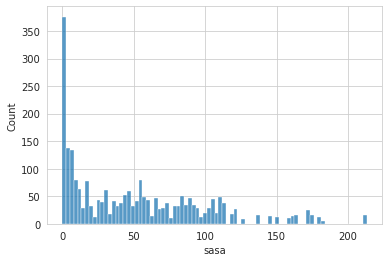

In [29]:
sns.histplot(test.sasa,bins=80)

### Edit type

In [30]:
test.edit_type.value_counts()

substitution    2335
deletion          77
-1                 1
Name: edit_type, dtype: int64

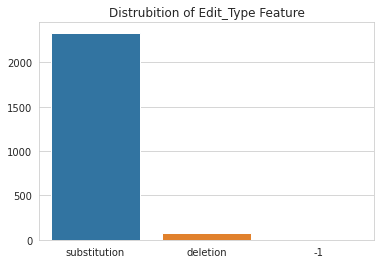

In [31]:
et = test.edit_type.value_counts()
sns.barplot(x=et.index,y=et.values);
plt.title('Distrubition of Edit_Type Feature');

### Edit Index

In [32]:
len(test.edit_idx.value_counts())

202

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


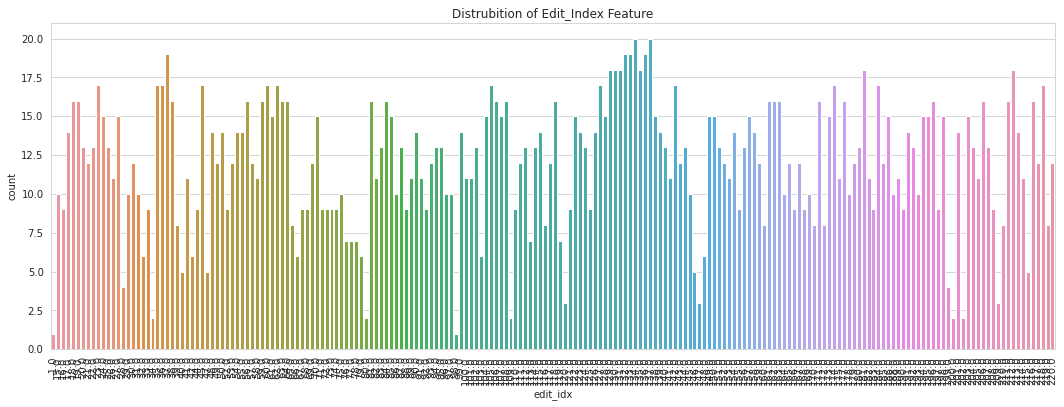

In [33]:
plt.figure(figsize=(18,6))
ei = test.edit_idx.value_counts()
sns.countplot(test.edit_idx)
plt.title('Distrubition of Edit_Index Feature')
plt.xticks(rotation=90);

### Wildtype_aa and mutant_aa

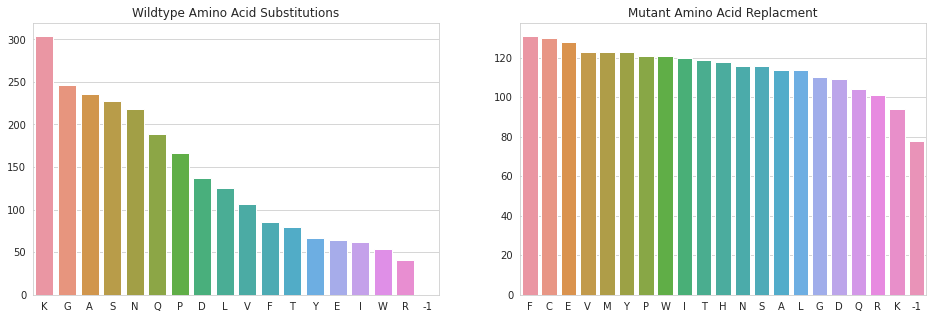

In [34]:
wtc = test.wildtype_aa.value_counts()
mc = test.mutant_aa.value_counts()

plt.figure(figsize= (16,5))
plt.subplot(1,2,1)
sns.barplot(x=wtc.index,y=wtc.values)
plt.title('Wildtype Amino Acid Substitutions')
plt.subplot(1,2,2)
sns.barplot(x=mc.index,y=mc.values)
plt.title('Mutant Amino Acid Replacment');

### Data source

In [35]:
train.data_source.value_counts()

doi.org/10.1038/s41592-020-0801-4    24525
10.1021/acscatal.9b05223               211
10.1016/j.bpc.2006.10.014              185
10.7554/eLife.54639                    151
10.1007/s00253-018-8872-1               84
                                     ...  
10.1074/jbc.M001132200                   1
10.1021/bi9530090                        1
10.1016/j.ijbiomac.2008.12.016           1
10.1016/j.jmb.2004.02.073                1
10.1021/bi00219a037                      1
Name: data_source, Length: 324, dtype: int64

### Other features from BioPython

In [36]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
test["stability_analysis"] = test["protein_sequence"].apply(lambda x: ProteinAnalysis(x).instability_index())
test["aromaticity_analysis"] = test["protein_sequence"].apply(lambda x: ProteinAnalysis(x).aromaticity())
test["isoelectric_analysis"] = test["protein_sequence"].apply(lambda x: ProteinAnalysis(x).isoelectric_point())
test["charge_analysis"] = test["protein_sequence"].apply(lambda x: ProteinAnalysis(x).charge_at_pH(8.0))
test["helix_analysis"] = test["protein_sequence"].apply(lambda x: ProteinAnalysis(x).secondary_structure_fraction()[0])
test["turn_analysis"] = test["protein_sequence"].apply(lambda x: ProteinAnalysis(x).secondary_structure_fraction()[1])
test["sheet_analysis"] = test["protein_sequence"].apply(lambda x: ProteinAnalysis(x).secondary_structure_fraction()[2])
test["mec_analysis_1"] = test["protein_sequence"].apply(lambda x: ProteinAnalysis(x).molar_extinction_coefficient()[0])
test["mec_analysis_2"] = test["protein_sequence"].apply(lambda x: ProteinAnalysis(x).molar_extinction_coefficient()[1])
test["gravy_analysis"] = test["protein_sequence"].apply(lambda x: ProteinAnalysis(x).gravy())
test


,seq_id,protein_sequence,pH,data_source,edit_type,edit_idx,wildtype_aa,mutant_aa,sasa,stability_analysis,aromaticity_analysis,isoelectric_analysis,charge_analysis,helix_analysis,turn_analysis,sheet_analysis,mec_analysis_1,mec_analysis_2,gravy_analysis
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,16.0,L,E,170.882740,43.819955,0.099548,8.751535,2.558953,0.230769,0.330317,0.180995,41940,42190,-0.771041
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,16.0,L,K,170.882740,43.819955,0.099548,9.024494,4.548770,0.230769,0.330317,0.176471,41940,42190,-0.772851
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,deletion,16.0,L,-1,170.882740,43.973682,0.100000,8.907484,3.558671,0.231818,0.331818,0.177273,41940,42190,-0.758636
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,17.0,K,C,71.392633,45.295068,0.099548,8.699638,2.477663,0.235294,0.330317,0.180995,41940,42190,-0.709050
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,17.0,K,F,71.392633,43.819955,0.104072,8.761012,2.568572,0.239819,0.330317,0.180995,41940,42190,-0.707692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,15.0,A,I,55.403077,44.307285,0.099548,8.907484,3.558671,0.239819,0.330317,0.176471,41940,42190,-0.725792
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,15.0,A,L,55.403077,43.435792,0.099548,8.907484,3.558671,0.239819,0.330317,0.180995,41940,42190,-0.728959
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,15.0,A,N,55.403077,43.435792,0.099548,8.907484,3.558671,0.235294,0.334842,0.176471,41940,42190,-0.761991
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,substitution,15.0,A,P,55.403077,44.307285,0.099548,8.907484,3.558671,0.235294,0.334842,0.176471,41940,42190,-0.753394


## Submission

In [37]:
# This will score 0.397, and .415 with blossom62
ss["tm"] = test["sasa"]
ss.to_csv("submission.csv", index=False)

Scores .397 with SASA on test alone